In [1]:
#remember to clone https://github.com/brcondor/Architectures_for_Big_Data into '/home/jovyan/work/'
import sys
sys.path.append("/home/jovyan/work/Architectures_for_Big_Data/")
import pyspark
sc = pyspark.SparkContext("local[3]")

In [2]:
sys.path.append("/home/jovyan/Architectures_For_Big_Data/")

In [3]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *

dataset = datasetGenerator()
dataset.addGenerator(idGenerator(),prefix="line",min=1,max=5,keyName="lineId")
dataset.addGenerator(idGenerator(),prefix="item",min=1,max=15,keyName="itemId")
dataset.addGenerator(tickGenerator(),minTick=600,maxTick=1800,keyName="creationDate")
dataset.addGenerator(intGenerator(),keyName="qty")

logRdd = sc.parallelize( dataset.generateDataset(25000)).persist()
logRdd.first()

{'lineId': 'line_04',
 'itemId': 'item_005',
 'creationDate': datetime.datetime(2010, 1, 1, 0, 3, 26),
 'qty': 547}

In [4]:
logRdd.map(lambda x: x.get("creationDate")).sortBy(lambda x: x).map(lambda x: str(x)).take(5)

['2010-01-01 00:03:26',
 '2010-01-01 00:19:22',
 '2010-01-01 00:44:30',
 '2010-01-01 01:07:01',
 '2010-01-01 01:30:18']

In [5]:
logRdd.map(lambda x: (x.get("lineId"),x.get("itemId"))).distinct().sortBy(lambda x: (x[0],x[1])).collect()

[('line_01', 'item_001'),
 ('line_01', 'item_002'),
 ('line_01', 'item_003'),
 ('line_01', 'item_004'),
 ('line_01', 'item_005'),
 ('line_01', 'item_006'),
 ('line_01', 'item_007'),
 ('line_01', 'item_008'),
 ('line_01', 'item_009'),
 ('line_01', 'item_010'),
 ('line_01', 'item_011'),
 ('line_01', 'item_012'),
 ('line_01', 'item_013'),
 ('line_01', 'item_014'),
 ('line_01', 'item_015'),
 ('line_02', 'item_001'),
 ('line_02', 'item_002'),
 ('line_02', 'item_003'),
 ('line_02', 'item_004'),
 ('line_02', 'item_005'),
 ('line_02', 'item_006'),
 ('line_02', 'item_007'),
 ('line_02', 'item_008'),
 ('line_02', 'item_009'),
 ('line_02', 'item_010'),
 ('line_02', 'item_011'),
 ('line_02', 'item_012'),
 ('line_02', 'item_013'),
 ('line_02', 'item_014'),
 ('line_02', 'item_015'),
 ('line_03', 'item_001'),
 ('line_03', 'item_002'),
 ('line_03', 'item_003'),
 ('line_03', 'item_004'),
 ('line_03', 'item_005'),
 ('line_03', 'item_006'),
 ('line_03', 'item_007'),
 ('line_03', 'item_008'),
 ('line_03',

In [6]:
logRdd.map(lambda x: (x.get("lineId"),x.get("itemId"))).distinct().map(lambda x: (x[0],1))\
        .reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[0]).collect()

[('line_01', 15),
 ('line_02', 15),
 ('line_03', 15),
 ('line_04', 15),
 ('line_05', 15)]

In [7]:
maxDate = logRdd.map(lambda x: x.get("creationDate")).max()
str(maxDate)


'2010-09-18 08:02:20'

In [8]:
from dataGenerator.rowGenerator import *
from dataGenerator.datasetGenerator import *

dataset = datasetGenerator()
dataset.addGenerator(idGenerator(),prefix="line",min=1,max=5,keyName="lineId")
dataset.addGenerator(idGenerator(),prefix="item",min=1,max=15,keyName="itemId")
dataset.addGenerator(dateGenerator(),endDate=maxDate,keyName="registryInsertTimestamp")
dataset.addGenerator(intGenerator(),"cost")

masterDataRdd = sc.parallelize( dataset.generateDataset(1500)).persist()
masterDataRdd.first()

{'lineId': 'line_01',
 'itemId': 'item_015',
 'registryInsertTimestamp': datetime.datetime(2010, 5, 14, 16, 25, 22),
 'cost': 586}

In [9]:
masterDataRdd.map(lambda x: x.get("registryInsertTimestamp")).max()

datetime.datetime(2010, 9, 18, 3, 39, 17)

# Bean Counter

In [10]:
logRdd.first()

{'lineId': 'line_04',
 'itemId': 'item_005',
 'creationDate': datetime.datetime(2010, 1, 1, 0, 3, 26),
 'qty': 547}

## How many lines per item?

In [11]:
logRdd.map(lambda x: (x.get("itemId"),1)).reduceByKey(lambda x,y: x+y).take(5)

[('item_005', 1669),
 ('item_002', 1691),
 ('item_013', 1655),
 ('item_007', 1690),
 ('item_001', 1594)]

## How much qty per item?

In [12]:
def f(x,y):
    numberOfItems = x+y
    return numberOfItems
logRdd.map(lambda x: (x.get("itemId"),x.get("qty"))).reduceByKey(lambda x,y: f(x,y)).top(100,lambda x: x[0])

[('item_015', 818022),
 ('item_014', 839992),
 ('item_013', 836378),
 ('item_012', 837823),
 ('item_011', 809277),
 ('item_010', 830968),
 ('item_009', 853258),
 ('item_008', 869864),
 ('item_007', 851348),
 ('item_006', 828030),
 ('item_005', 821762),
 ('item_004', 838623),
 ('item_003', 847155),
 ('item_002', 824939),
 ('item_001', 806247)]

In [13]:
def f(x,y):
    numberOfItems = x+y
    return numberOfItems
logRdd.map(lambda x: (x.get("itemId"),x.get("qty"))).reduceByKey(lambda x,y: f(x,y))\
                    .top(100,key=lambda x: 1/int(x[0].split("_")[1]))

[('item_001', 806247),
 ('item_002', 824939),
 ('item_003', 847155),
 ('item_004', 838623),
 ('item_005', 821762),
 ('item_006', 828030),
 ('item_007', 851348),
 ('item_008', 869864),
 ('item_009', 853258),
 ('item_010', 830968),
 ('item_011', 809277),
 ('item_012', 837823),
 ('item_013', 836378),
 ('item_014', 839992),
 ('item_015', 818022)]

## How much qty in average per item?

In [14]:
def f(x,y):
    cumulateQty = x[0]+y[0]
    numberOfItems = x[1]+y[1]
    return cumulateQty,numberOfItems
    
def prepare(x):
    return x[0],x[1][0]/x[1][1]
    
logRdd.map(lambda x: (x.get("itemId"),(x.get("qty"),1.0))).reduceByKey(lambda x,y: f(x,y)).map(lambda x: prepare(x)).take(5)

[('item_005', 492.36788496105453),
 ('item_002', 487.8409225310467),
 ('item_013', 505.3643504531722),
 ('item_007', 503.75621301775146),
 ('item_001', 505.80112923462985)]

In [15]:
def f(x,y):
    cumulateQty = x[0]+y[0]
    numberOfItems = x[1]+y[1]
    return cumulateQty,numberOfItems
    
def prepare(x):
    return x[1][0]/x[1][1]
    
logRdd.map(lambda x: (x.get("itemId"),(x.get("qty"),1.0))).reduceByKey(lambda x,y: f(x,y)).map(lambda x: prepare(x))\
                .stats()

(count: 15, mean: 500.60584911680183, stdev: 7.234148765253771, max: 513.1941002949852, min: 487.8409225310467)

## Exercise (1): Similar statistics but on item,line couple

In [16]:
def f(x,y):
    cumulateQty = x[0]+y[0]
    numberOfItems = x[1]+y[1]
    return cumulateQty,numberOfItems
    
def prepare(x):
    return x[1][0]/x[1][1]
    
logRdd.map(lambda x: ((x.get("itemId"),x.get("lineId")),(x.get("qty"),1.0))).reduceByKey(lambda x,y: f(x,y)).map(lambda x: prepare(x))\
                .stats()

(count: 75, mean: 500.60703310028487, stdev: 14.960957506452562, max: 542.6656346749226, min: 452.1888544891641)

## lets Imagine to have 100 executors, and we want to distribute the average over lineId

In [17]:
def f(x,y):
    cumulateQty = x[0]+y[0]
    numberOfItems = x[1]+y[1]
    return cumulateQty,numberOfItems
    
def prepare(x):
    return x[1][0]/x[1][1]
    
logRdd.map(lambda x: ((x.get("lineId")),(x.get("qty"),1.0))).reduceByKey(lambda x,y: f(x,y))\
                    .map(lambda x: prepare(x))\
                .stats()

(count: 5, mean: 500.5296348195367, stdev: 3.4180566960208516, max: 505.4915924826904, min: 495.1341026661361)

In [18]:
def f(x,y):
    cumulateQty = x[0]+y[0]
    numberOfItems = x[1]+y[1]
    return cumulateQty,numberOfItems
    
def prepare(x):
    return x[1][0]/x[1][1]
    
logRdd.map(lambda x: ((randint(1,100),x.get("lineId")),(x.get("qty"),1.0))).reduceByKey(lambda x,y: f(x,y))\
                    .map(lambda x: (x[0][1],x[1])).reduceByKey(lambda x,y: f(x,y))\
                    .map(lambda x: prepare(x))\
                .stats()

(count: 5, mean: 500.5296348195367, stdev: 3.418056696020871, max: 505.4915924826904, min: 495.1341026661361)

## Cycle Time

In [19]:
semiLogRdd = logRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")),x)).persist()
semiLogRdd.take(5)

[(('line_04', 'item_005'),
  {'lineId': 'line_04',
   'itemId': 'item_005',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 3, 26),
   'qty': 547}),
 (('line_01', 'item_011'),
  {'lineId': 'line_01',
   'itemId': 'item_011',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 19, 22),
   'qty': 812}),
 (('line_03', 'item_011'),
  {'lineId': 'line_03',
   'itemId': 'item_011',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 44, 30),
   'qty': 846}),
 (('line_02', 'item_002'),
  {'lineId': 'line_02',
   'itemId': 'item_002',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 7, 1),
   'qty': 628}),
 (('line_05', 'item_002'),
  {'lineId': 'line_05',
   'itemId': 'item_002',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 30, 18),
   'qty': 892})]

In [20]:
joinedRDD = semiLogRdd.join(semiLogRdd).persist()
joinedRDD.count()
#8.355.962

8355182

In [21]:
joinedRDD.first()

(('line_04', 'item_013'),
 ({'lineId': 'line_04',
   'itemId': 'item_013',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 34, 21),
   'qty': 800},
  {'lineId': 'line_04',
   'itemId': 'item_013',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 34, 21),
   'qty': 800}))

In [22]:
triangleJoinedRdd = joinedRDD.filter(lambda x: x[1][0].get("creationDate")<x[1][1].get("creationDate")).persist()
triangleJoinedRdd.count()

4165091

In [23]:
triangleJoinedRdd.first()

(('line_04', 'item_013'),
 ({'lineId': 'line_04',
   'itemId': 'item_013',
   'creationDate': datetime.datetime(2010, 1, 1, 1, 34, 21),
   'qty': 800},
  {'lineId': 'line_04',
   'itemId': 'item_013',
   'creationDate': datetime.datetime(2010, 1, 1, 18, 8, 41),
   'qty': 656}))

In [24]:
tempRdd = triangleJoinedRdd.map(lambda x: ((x[0],x[1][0].get("creationDate")), 
                                 (x[1][1].get("creationDate")-x[1][0].get("creationDate"),x)))
tempRdd.first()

((('line_04', 'item_013'), datetime.datetime(2010, 1, 1, 1, 34, 21)),
 (datetime.timedelta(seconds=59660),
  (('line_04', 'item_013'),
   ({'lineId': 'line_04',
     'itemId': 'item_013',
     'creationDate': datetime.datetime(2010, 1, 1, 1, 34, 21),
     'qty': 800},
    {'lineId': 'line_04',
     'itemId': 'item_013',
     'creationDate': datetime.datetime(2010, 1, 1, 18, 8, 41),
     'qty': 656}))))

In [25]:
sampleLine = tempRdd.first()[0]
print(sampleLine)
triangleJoinedRdd.map(lambda x: ((x[0],x[1][0].get("creationDate")), 
                                 (x[1][1].get("creationDate")-x[1][0].get("creationDate"),x)))\
                .filter(lambda x: x[0]==sampleLine).count()

(('line_04', 'item_013'), datetime.datetime(2010, 1, 1, 1, 34, 21))


305

In [26]:
def f(x,y):
    if x[0]<y[0]:
        return x
    return y

def prepare(x):
    x[1][1][1][0]["cycleTime"] = x[1][0]
    return x[1][1][1][0]
    
enrichedLogRdd = triangleJoinedRdd.map(lambda x: ((x[0],x[1][0].get("creationDate")), 
                                                  (x[1][1].get("creationDate")-x[1][0].get("creationDate"),x)))\
                    .reduceByKey(lambda x,y: f(x,y)).map(lambda x: prepare(x)).persist()
enrichedLogRdd.take(5)

[{'lineId': 'line_04',
  'itemId': 'item_013',
  'creationDate': datetime.datetime(2010, 1, 10, 21, 39, 2),
  'qty': 39,
  'cycleTime': datetime.timedelta(seconds=61565)},
 {'lineId': 'line_04',
  'itemId': 'item_013',
  'creationDate': datetime.datetime(2010, 1, 11, 14, 52, 43),
  'qty': 412,
  'cycleTime': datetime.timedelta(seconds=17616)},
 {'lineId': 'line_04',
  'itemId': 'item_013',
  'creationDate': datetime.datetime(2010, 1, 13, 19, 9, 56),
  'qty': 481,
  'cycleTime': datetime.timedelta(days=1, seconds=15362)},
 {'lineId': 'line_04',
  'itemId': 'item_013',
  'creationDate': datetime.datetime(2010, 1, 14, 23, 25, 58),
  'qty': 268,
  'cycleTime': datetime.timedelta(days=1, seconds=37106)},
 {'lineId': 'line_04',
  'itemId': 'item_013',
  'creationDate': datetime.datetime(2010, 1, 19, 14, 36, 19),
  'qty': 871,
  'cycleTime': datetime.timedelta(seconds=39297)}]

## Exercise (2): why if we count, we see fewer items?

In [27]:
enrichedLogRdd.count()

24925

In [28]:
def max_date(x,y):
    return x if x > y else y
    

maxLogRdd = semiLogRdd.map(lambda x: ((x[1].get('lineId'), x[1].get('itemId')), x[1].get('creationDate'))).reduceByKey(max_date).persist()

maxLogRdd.count()

75

### Mancano le combinazioni tuple line per cui la creation date è massima, poichè, quando creo triangleJoinedRdd, per le tuple con creation date massima non vale la condizione

## Exercise (3): I want to see the histogram of cycle times

In [29]:
import pandas as pd

<AxesSubplot:xlabel='bin'>

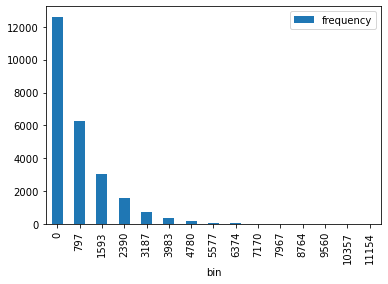

In [30]:
#in minuti
hist = enrichedLogRdd.map(lambda x: (x['cycleTime'].total_seconds())/60).histogram(15)

for i, b in enumerate(hist[0]):
    hist[0][i] = round(b)

pd.DataFrame(
    list(zip(*hist)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar') 

## Extract Snapshot from Master Data

In [27]:
tempRdd = masterDataRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")), (x.get("cost"),x.get("registryInsertTimestamp")) )  )
tempRdd.first()

(('line_05', 'item_011'), (140, datetime.datetime(2010, 1, 3, 20, 1, 2)))

In [28]:
masterDataRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")))).distinct().count()

75

In [29]:
sampleLine = tempRdd.first()[0]
print(sampleLine)
masterDataRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")), (x.get("cost"),str(x.get("registryInsertTimestamp"))) )  )\
            .filter(lambda x: x[0]==sampleLine).sortBy(lambda x: x[1][1]).collect()

('line_05', 'item_011')


[(('line_05', 'item_011'), (140, '2010-01-03 20:01:02')),
 (('line_05', 'item_011'), (49, '2010-01-05 00:48:26')),
 (('line_05', 'item_011'), (917, '2010-01-25 03:33:07')),
 (('line_05', 'item_011'), (585, '2010-01-25 15:39:27')),
 (('line_05', 'item_011'), (659, '2010-02-08 17:34:10')),
 (('line_05', 'item_011'), (915, '2010-02-24 03:03:19')),
 (('line_05', 'item_011'), (662, '2010-03-02 17:03:58')),
 (('line_05', 'item_011'), (598, '2010-03-11 09:08:41')),
 (('line_05', 'item_011'), (967, '2010-03-20 09:19:51')),
 (('line_05', 'item_011'), (150, '2010-04-19 15:11:03')),
 (('line_05', 'item_011'), (718, '2010-05-17 21:29:19')),
 (('line_05', 'item_011'), (493, '2010-07-02 08:46:49')),
 (('line_05', 'item_011'), (91, '2010-07-06 21:45:30')),
 (('line_05', 'item_011'), (300, '2010-07-19 10:45:42')),
 (('line_05', 'item_011'), (485, '2010-07-22 13:47:25')),
 (('line_05', 'item_011'), (757, '2010-07-22 13:48:36')),
 (('line_05', 'item_011'), (987, '2010-07-24 04:48:30')),
 (('line_05', 'i

In [59]:
masterDataRdd.count()

1500

In [60]:
masterDataRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")), (x.get("cost"),str(x.get("registryInsertTimestamp"))) )  )\
            .reduceByKey(lambda x,y: x if x[1]>y[1] else y).collect()

[(('line_05', 'item_010'), (899, '2010-09-13 04:52:02')),
 (('line_04', 'item_011'), (517, '2010-09-01 09:03:16')),
 (('line_04', 'item_015'), (446, '2010-09-17 16:30:51')),
 (('line_05', 'item_008'), (595, '2010-09-06 08:48:14')),
 (('line_01', 'item_005'), (959, '2010-09-08 10:38:32')),
 (('line_02', 'item_004'), (874, '2010-09-15 17:36:34')),
 (('line_02', 'item_011'), (426, '2010-09-06 16:49:19')),
 (('line_02', 'item_014'), (219, '2010-09-17 02:05:26')),
 (('line_03', 'item_004'), (756, '2010-09-16 13:09:10')),
 (('line_01', 'item_011'), (571, '2010-08-31 00:15:53')),
 (('line_03', 'item_014'), (517, '2010-08-25 08:36:26')),
 (('line_02', 'item_005'), (615, '2010-09-06 02:24:03')),
 (('line_05', 'item_005'), (348, '2010-09-16 17:27:34')),
 (('line_05', 'item_001'), (890, '2010-09-08 09:05:51')),
 (('line_03', 'item_005'), (254, '2010-08-26 12:09:20')),
 (('line_04', 'item_002'), (191, '2010-09-13 17:36:05')),
 (('line_01', 'item_003'), (187, '2010-09-11 17:18:10')),
 (('line_01', 

# Join over time

In [30]:
print(sampleLine)
logRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")), str(x.get("creationDate"))) )\
            .filter(lambda x: x[0]==(sampleLine)).sortBy(lambda x: x[1][1]).collect()

('line_05', 'item_011')


[(('line_05', 'item_011'), '2010-01-01 22:20:34'),
 (('line_05', 'item_011'), '2010-01-03 07:30:05'),
 (('line_05', 'item_011'), '2010-01-03 12:00:25'),
 (('line_05', 'item_011'), '2010-01-05 05:14:15'),
 (('line_05', 'item_011'), '2010-01-05 18:17:39'),
 (('line_05', 'item_011'), '2010-01-06 05:37:04'),
 (('line_05', 'item_011'), '2010-01-06 12:05:23'),
 (('line_05', 'item_011'), '2010-01-06 12:16:16'),
 (('line_05', 'item_011'), '2010-01-07 02:15:03'),
 (('line_05', 'item_011'), '2010-01-08 12:19:32'),
 (('line_05', 'item_011'), '2010-01-09 00:43:43'),
 (('line_05', 'item_011'), '2010-01-09 22:35:48'),
 (('line_05', 'item_011'), '2010-01-10 07:21:15'),
 (('line_05', 'item_011'), '2010-01-12 11:25:08'),
 (('line_05', 'item_011'), '2010-01-12 20:40:51'),
 (('line_05', 'item_011'), '2010-01-12 22:03:13'),
 (('line_05', 'item_011'), '2010-01-15 16:51:39'),
 (('line_05', 'item_011'), '2010-01-16 07:24:05'),
 (('line_05', 'item_011'), '2010-01-18 00:17:28'),
 (('line_05', 'item_011'), '201

## Step1: start with all possible combinations of log/master regardless the timestamp

In [31]:
step1 = logRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")),x))\
                .join(masterDataRdd.map(lambda x: ((x.get("lineId"),x.get("itemId")),x)))
step1.first()

(('line_03', 'item_007'),
 ({'lineId': 'line_03',
   'itemId': 'item_007',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 23, 19),
   'qty': 819},
  {'lineId': 'line_03',
   'itemId': 'item_007',
   'registryInsertTimestamp': datetime.datetime(2010, 5, 13, 5, 31, 53),
   'cost': 162}))

## Step2: reshape the rdd to create the unique ID needed - (lineId,ItemId,creationDate)

In [32]:
#log data is leading
def linePrepare(row):
    key = (row[0],row[1][0].get("creationDate"))
    value = {"deltaTime":row[1][0].get("creationDate")-row[1][1].get("registryInsertTimestamp"),
            "logLine":row[1][0],"masterLine":row[1][1]}
    return {"key":key,"value":value}

step2 = step1.map(lambda x: linePrepare(x)).persist()
step2.first()

{'key': (('line_03', 'item_007'), datetime.datetime(2010, 1, 1, 0, 23, 19)),
 'value': {'deltaTime': datetime.timedelta(days=-133, seconds=67886),
  'logLine': {'lineId': 'line_03',
   'itemId': 'item_007',
   'creationDate': datetime.datetime(2010, 1, 1, 0, 23, 19),
   'qty': 819},
  'masterLine': {'lineId': 'line_03',
   'itemId': 'item_007',
   'registryInsertTimestamp': datetime.datetime(2010, 5, 13, 5, 31, 53),
   'cost': 162}}}

## Step3: Reducing to Select only the correct value

In [33]:
def reduceFun(val1,val2):
    return val1 if val1.get("deltaTime") < val2.get("deltaTime") else val2

step3 = step2.map(lambda x: (x.get("key"),x.get("value"))).reduceByKey(lambda x,y: reduceFun(x,y))
step3.count()

25000

In [34]:
## it looks like correct... lets make a check
step3.filter(lambda x: x[1].get("deltaTime")<timedelta(0)).first() ##a negative value?

((('line_03', 'item_007'), datetime.datetime(2010, 1, 2, 21, 32, 12)),
 {'deltaTime': datetime.timedelta(days=-239, seconds=85817),
  'logLine': {'lineId': 'line_03',
   'itemId': 'item_007',
   'creationDate': datetime.datetime(2010, 1, 2, 21, 32, 12),
   'qty': 316},
  'masterLine': {'lineId': 'line_03',
   'itemId': 'item_007',
   'registryInsertTimestamp': datetime.datetime(2010, 8, 28, 21, 41, 55),
   'cost': 405}})

In [35]:
def lineFormatter(row):
    masterLine = row.get("value").get("masterLine")
    return "[{ts}] - {cost}€".format(ts=masterLine.get("registryInsertTimestamp"),cost=masterLine.get("cost"))
sampleRowKey = step2.first().get("key")
print("{line}-{item} @{ts}".format(ts=str(sampleRowKey[1]),
                          line=sampleRowKey[0][0],item=sampleRowKey[0][1]))
print("\t"+"\n\t".join([lineFormatter(k) for k in step2.filter(lambda x: x.get("key") == sampleRowKey).take(20)]))

line_03-item_007 @2010-01-01 00:23:19
	[2010-05-13 05:31:53] - 162€
	[2010-06-06 13:36:42] - 2€
	[2010-06-27 13:22:35] - 740€
	[2010-02-27 09:51:45] - 827€
	[2010-04-19 13:25:48] - 274€
	[2010-06-10 13:07:17] - 764€
	[2010-08-18 04:06:47] - 804€
	[2010-08-08 21:54:03] - 899€
	[2010-02-18 15:43:40] - 901€
	[2010-04-09 19:29:54] - 853€
	[2010-08-28 21:41:55] - 405€
	[2010-05-03 20:55:50] - 393€
	[2010-03-10 10:20:25] - 790€
	[2010-02-28 10:11:34] - 689€
	[2010-01-19 13:04:33] - 631€
	[2010-07-30 01:41:43] - 948€


In [36]:
sampleRowKey2 = step2.filter(lambda x: x.get("key")[1]>datetime(2010,4,1)).first().get("key")
print("{line}-{item} @{ts}".format(ts=str(sampleRowKey2[1]),
                          line=sampleRowKey2[0][0],item=sampleRowKey2[0][1]))
print("\t"+"\n\t".join([lineFormatter(k) for k in step2.filter(lambda x: x.get("key") == sampleRowKey2)\
                        .top(25,key=lambda x: x.get("value").get("masterLine").get("registryInsertTimestamp"))]))

line_03-item_007 @2010-04-01 03:59:43
	[2010-08-28 21:41:55] - 405€
	[2010-08-18 04:06:47] - 804€
	[2010-08-08 21:54:03] - 899€
	[2010-07-30 01:41:43] - 948€
	[2010-06-27 13:22:35] - 740€
	[2010-06-10 13:07:17] - 764€
	[2010-06-06 13:36:42] - 2€
	[2010-05-13 05:31:53] - 162€
	[2010-05-03 20:55:50] - 393€
	[2010-04-19 13:25:48] - 274€
	[2010-04-09 19:29:54] - 853€
	[2010-03-10 10:20:25] - 790€
	[2010-02-28 10:11:34] - 689€
	[2010-02-27 09:51:45] - 827€
	[2010-02-18 15:43:40] - 901€
	[2010-01-19 13:04:33] - 631€


## Step3: lets try again!

In [37]:
def reduceFun(val1,val2):
    return val1 if val1.get("deltaTime") < val2.get("deltaTime") else val2
step3_1 = step2.map(lambda x: (x.get("key"),x.get("value"))).filter(lambda x: x[1].get("deltaTime")>=timedelta(0))\
            .reduceByKey(lambda x,y: reduceFun(x,y))
step3_1.count()

23734

why 23883?? we lost some rows

In [38]:
def lineMaker(row):
    return (row.get("key"),(0,0,1) if row.get("value").get("deltaTime")>timedelta(0) 
                                            else (0,1,0) if row.get("value").get("deltaTime") == 0
                                            else (1,0,0))
    
rowDistribution = step2.map(lambda x: lineMaker(x)).reduceByKey(lambda x,y: (x[0]+y[0],x[1]+y[1],x[2]+y[2])).persist()
[(k[0][0],k[1]) for k in rowDistribution.collect() if k[1][2] == 0]

[(('line_03', 'item_007'), (16, 0, 0)),
 (('line_03', 'item_007'), (16, 0, 0)),
 (('line_03', 'item_005'), (16, 0, 0)),
 (('line_03', 'item_005'), (16, 0, 0)),
 (('line_03', 'item_005'), (16, 0, 0)),
 (('line_03', 'item_005'), (16, 0, 0)),
 (('line_05', 'item_008'), (29, 0, 0)),
 (('line_05', 'item_008'), (29, 0, 0)),
 (('line_05', 'item_008'), (29, 0, 0)),
 (('line_05', 'item_008'), (29, 0, 0)),
 (('line_05', 'item_008'), (29, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_04', 'item_002'), (20, 0, 0)),
 (('line_03', 'item_004'), (19, 0, 0)),
 (('line_03', 'item_004'), (19, 0, 0)),
 (('line_03', 'item_004'), (19, 0, 0)),
 (('line_03', 'item_004'), (19, 0, 0)),
 (('line_03', 'item_004'), (19, 0, 0)),


In [44]:
len([(k[0][0],k[1]) for k in rowDistribution.collect() if k[1][2] == 0]),len([(k[0][0],k[1]) for k in rowDistribution.collect() if k[1][2] == 0]) + step3_1.count()

(1266, 25000)

## Step3.ter maybe this is the good one

In [40]:
def reduceFun(val1,val2):
    val1Delta = val1.get("deltaTime")
    val2Delta = val2.get("deltaTime")
    if val1Delta >= timedelta(0) and val2Delta >=timedelta(0):
        return val1 if  val1Delta < val2Delta else val2
    elif val1Delta < timedelta(0) and val2Delta <timedelta(0): 
        return val1 if  val1Delta > val2Delta else val2
    else: 
        return val1 if val1Delta>=timedelta(0) else val2
        
def lineParser(row):
    return {"lineId":row[0][0][0],"itemId":row[0][0][1],"creationDate":row[0][1], "deltaTime":row[1].get("deltaTime"),
                 "qty":row[1].get("logLine").get("qty"),"cost":row[1].get("masterLine").get("cost")}


step3_2 = step2.map(lambda x: (x.get("key"),x.get("value")))\
            .reduceByKey(lambda x,y: reduceFun(x,y)).map(lambda x: lineParser(x))
step3_2.count()

25000

In [41]:
step3_0 = step3.map(lambda x: lineParser(x))
step3_0.filter(lambda x: x.get("deltaTime")<timedelta(0)).count(),step3_0.filter(lambda x: x.get("deltaTime")>=timedelta(0)).count()

(23989, 1011)

In [42]:
step3_1_0 = step3_1.map(lambda x: lineParser(x))
step3_1_0.filter(lambda x: x.get("deltaTime")<timedelta(0)).count(),step3_1_0.filter(lambda x: x.get("deltaTime")>=timedelta(0)).count()

(0, 23734)

In [43]:
step3_2.filter(lambda x: x.get("deltaTime")<timedelta(0)).count(),step3_2.filter(lambda x: x.get("deltaTime")>=timedelta(0)).count()

(1266, 23734)